# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [ ]:
#!L
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time (8-10 minutes)
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

    # alternative way: 
    #from gfile import download_list
    #download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
    #               filename=FILENAME, target_dir=TARGET_DIR)

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [ ]:
!unzip -qq celeba.zip

## Prepare the data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import clear_output

import tqdm
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torch.nn import functional as F

import torchvision
from torchvision.utils import make_grid

from itertools import islice

device = torch.device("cuda:7")

In [2]:
class CropCelebA64:
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [4]:
train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

In [ ]:
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [5]:
BATCH_SIZE = 64

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [6]:
dimZ = 100  # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics


class Autoencoder(nn.Module):
    enc_channels = 128
    inp_size = 1, 64, 64
    inp_size_flatten = np.prod(inp_size)
    
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        self.encoder = nn.Sequential(
            nn.Linear(self.inp_size_flatten, self.enc_channels),
            nn.ReLU(),
            nn.Linear(self.enc_channels, dimZ),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, self.enc_channels),
            nn.ReLU(),
            nn.Linear(self.enc_channels, self.inp_size_flatten),
            nn.Sigmoid(),
        )
        
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)
    

    def forward(self, x):
        x = x.reshape(-1, self.inp_size_flatten)

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        reconstruction = reconstruction.reshape(-1, *self.inp_size)

        return reconstruction, latent_code

In [7]:
criterion = torch.nn.MSELoss()
autoencoder = Autoencoder().to(device)

optimizer = optim.Adam(autoencoder.parameters())

In [8]:
def pt2np(tensor):
    return tensor.cpu().detach().numpy()

running loss: 0.009702176786959171


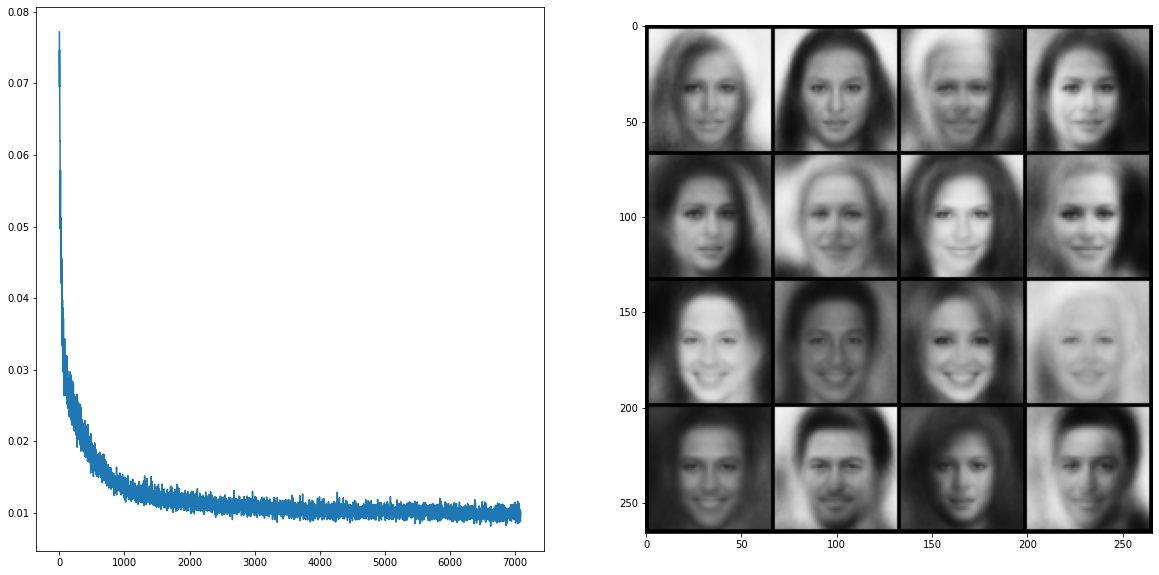

100%|██████████| 311/311 [00:28<00:00, 10.92it/s]


In [9]:
losses = []
for epoch in range(3):
    running_loss, batches_processed = 0.0, 0
    
    autoencoder.train(True)
    for batch, _ in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        rec, latent = autoencoder(batch)
        
        loss_val = criterion(rec, batch)
        loss_val.backward()
        optimizer.step()
        
        running_loss = running_loss * 0.9 + 0.1 * loss_val
        losses.append(pt2np(loss_val))
        batches_processed += 1
        
        if batches_processed % 1000 == 0:
            clear_output(wait=True)
            print(f'running loss: {running_loss}')
            
            f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
            ax1.plot(losses)
            reconstruction = rec[:16].cpu().detach()
            ax2.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
            plt.show()

with torch.no_grad():
    autoencoder.train(False)
    running_loss_val, batches_processed = 0.0, 0

    for val_num, (batch, _) in enumerate(tqdm.tqdm(val_loader)):
        batch = batch.to(device)
        rec, latent = autoencoder(batch)
        loss_val = criterion(rec, batch)

        running_loss_val = running_loss_val * 0.9 + 0.1 * loss_val


In [10]:
print(f'val loss: {running_loss_val}')

val loss: 0.01004419382661581


Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

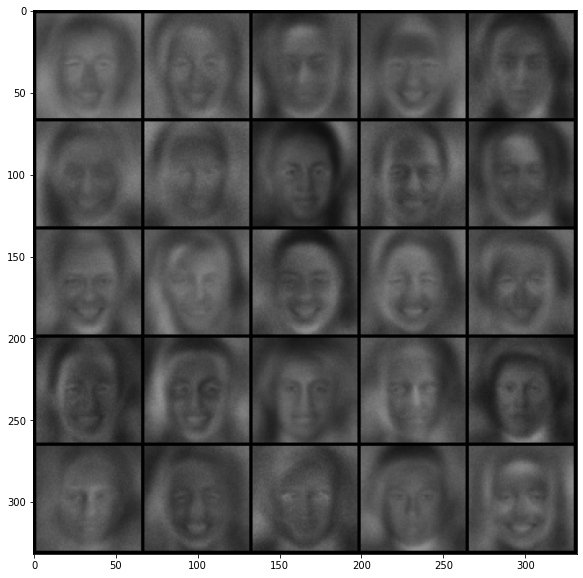

In [12]:
f, ax = plt.subplots(figsize=(10, 10))

autoencoder.eval()
with torch.no_grad():
    z = torch.randn(25, dimZ) * 0.5
    reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1)
    reconstruction = reconstruction.reshape(-1, *autoencoder.inp_size)

    ax.imshow(make_grid(reconstruction.cpu().detach(), nrow=5).permute(1, 2, 0))
    
plt.show()

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

#### Basic Conv AutoEncoder

In [440]:
dimZ = 128

def conv3_relu_pooling(inc, outc):
    return nn.Sequential(
        nn.Conv2d(inc, outc, kernel_size=3, padding=1),
        # nn.BatchNorm2d(outc),
        nn.InstanceNorm2d(outc),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

def upconv3_relu(inc, outc):    
    return nn.Sequential(
        nn.ConvTranspose2d(inc, outc, kernel_size=2, stride=2),
        nn.Conv2d(outc, outc, kernel_size=3, stride=1, padding=1),
        # nn.BatchNorm2d(outc),
        nn.InstanceNorm2d(outc),
        nn.LeakyReLU(),
    )

def mlp(channels):
    def dense_bn_relu(inc, outc):
        return nn.Sequential(
            nn.Linear(inc, outc),
            nn.LeakyReLU(),
        )
    
    return nn.Sequential(
        *[dense_bn_relu(i, o) for i, o in zip(channels[:-1], channels[1:])]
    )


class VAE(nn.Module):
    inp_size = 1, 64, 64
    inp_size_flatten = np.prod(inp_size)
    
    def __init__(self):
        super(VAE, self).__init__()
 
        self.encoder = nn.Sequential(
            conv3_relu_pooling(1, 32),  # to 32
            conv3_relu_pooling(32, 48),  # to 16
            conv3_relu_pooling(48, 64),  # to 8
            conv3_relu_pooling(64, 64),  # to 4
            nn.Flatten(),
        )
    
        self.encoder_mu = nn.Sequential(
            mlp([16 * 64, dimZ, dimZ]),
            nn.Linear(dimZ, dimZ)
        )
        
        self.encoder_logvar = nn.Sequential(
            mlp([16 * 64, dimZ, dimZ]),
            nn.Linear(dimZ, dimZ)
        )
        
        self.mapper = nn.Sequential(
            mlp([dimZ, dimZ]),
            nn.Linear(dimZ, 64 * 16),
        )
        
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),  # to 4
            upconv3_relu(64, 64),  # to 8
            upconv3_relu(64, 64),  # to 16
            upconv3_relu(64, 48),  # to 32
            upconv3_relu(48, 32),  # to 64
        )        

        
        self.decoder_mu = nn.Conv2d(32, 1, kernel_size=1)
        self.decoder_logvar = nn.Conv2d(32, 1, kernel_size=1)
        
        self.encoder_mu.apply(self.init_weights)
        self.encoder_logvar.apply(self.init_weights)
        
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        
        self.mapper.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)
            
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)
    
    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def forward(self, x, to_sample=True):
        latent = self.encoder(x)
        l_mu, l_logvar = self.encoder_mu(latent), self.encoder_logvar(latent)
        
        if to_sample:
            sample = self.gaussian_sampler(l_mu, l_logvar)
        else:
            sample = l_mu
        return (*self.decode(sample), l_mu, l_logvar)
    
    def decode(self, sample):
        rec_feat = self.decoder(self.mapper(sample))
        rec_mu = self.decoder_mu(rec_feat)
        rec_logvar = self.decoder_logvar(rec_feat)
        return rec_mu, rec_logvar

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [444]:
def KL_divergence(mu, logsigma):  
    mu = mu.mean(dim=0)
    logsigma = torch.log(torch.exp(2 * logsigma).mean(dim=0)) 
    in_batch = -0.5 * (1 + 2 * logsigma - mu ** 2 - torch.exp(2 * logsigma)).mean(dim=0)
    return in_batch.mean(dim=-1)


def log_likelihood(x, mu, logsigma):
    per_dim_values = -logsigma - (x - mu) ** 2 / (2 * torch.exp(2 * logsigma))
    # per_dim_values = - (x - mu) ** 2
    return per_dim_values.view(per_dim_values.shape[0], -1).mean(dim=-1)
    
    # return -F.mse_loss(x, mu)


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return {
        'kl': KL_divergence(mu_z, logsigma_z).mean(),
        'log_likelihood': -log_likelihood(x, mu_gen, logsigma_gen).mean(),
        'mse_loss': F.mse_loss(x, mu_gen)  # to pop and log to compare with ae
    }

And train the model:

In [445]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters())

running loss: 0.01561636384576559, mse: 0.015364380553364754, dict: {'kl': tensor(0.0511, device='cuda:7', grad_fn=<MeanBackward0>), 'log_likelihood': tensor(-1.7650, device='cuda:7', grad_fn=<NegBackward>)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


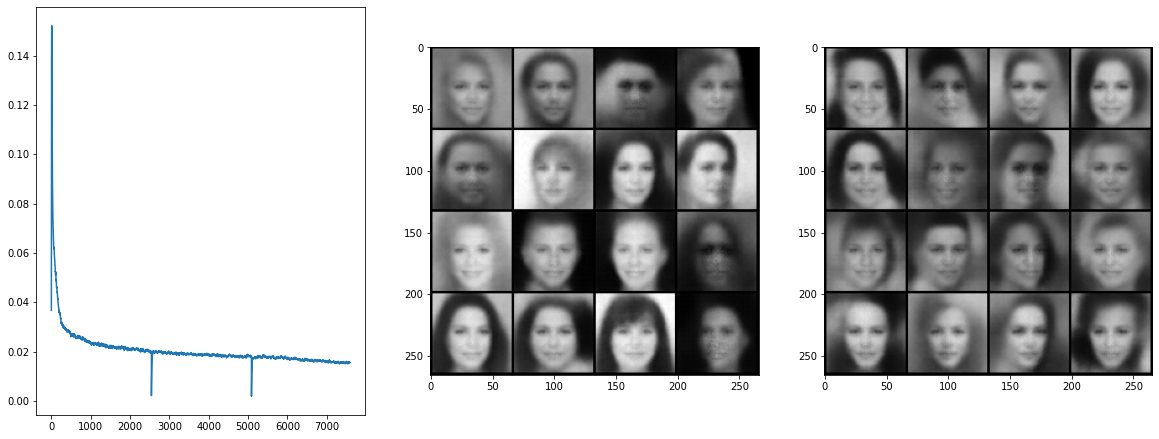

100%|██████████| 311/311 [00:30<00:00, 10.28it/s]


In [446]:
losses = []

for epoch in range(3):
    running_loss, batches_processed = 0.0, 0
    
    vae.train(True)
    for train_num, (batch, _) in enumerate(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        rec_mu, rec_logvar, l_mu, l_logvar = vae(batch)
        
        loss_dict = loss_vae(batch, rec_mu, rec_logvar, l_mu, l_logvar)
        
        mse_loss = loss_dict.pop('mse_loss')
                
        loss_val = sum(loss_dict.values())
        
        loss_val.backward()
        optimizer.step()
        
        running_loss = running_loss * 0.9 + 0.1 * mse_loss
        
        losses.append(running_loss)
        batches_processed += 1
        
        if batches_processed % 100 == 0:
            clear_output(wait=True)
            print(f'running loss: {running_loss}, mse: {mse_loss}, dict: {loss_dict}')
            f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 7.5))
            
            ax1.plot(losses)
            
            reconstruction = rec_mu[:16].cpu().detach()
            ax2.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
            
            rec_mu, rec_logvar = vae.decode(torch.randn(16, dimZ).to(device))
            reconstruction = rec_mu[:16].cpu().detach()
            ax3.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

            plt.show()

            
with torch.no_grad():
    running_val_loss, batches_processed = 0.0, 0

    for val_num, (batch, _) in enumerate(tqdm.tqdm(val_loader)):
        batch = batch.to(device)
        rec_mu, rec_logvar, l_mu, l_logvar = vae(batch, to_sample=False)

        loss_dict = loss_vae(batch, rec_mu, rec_logvar, l_mu, l_logvar)
        loss_val = sum(loss_dict.values())

        running_val_loss = running_val_loss * 0.9 + 0.1 * loss_dict.pop('mse_loss')


In [447]:
print(f'val loss: {running_val_loss}')

val loss: 0.014455503784120083


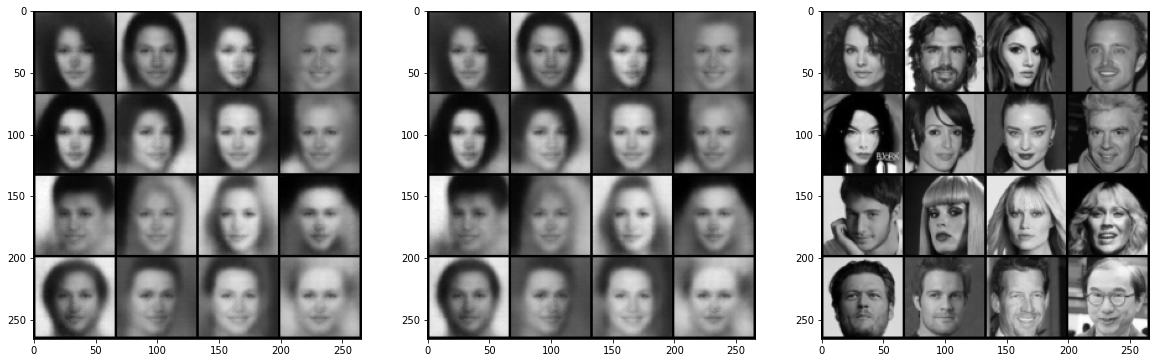

In [448]:
images, _ = list(islice(val_loader, 1))[0]
f, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 10), ncols=3)

mu_gen, _, mu_latent, _ = vae(images.to(device))
reconstruction = mu_gen[:16].cpu().clamp(0, 1).detach()
ax1.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

mu_gen, _, mu_latent, _ = vae(images.to(device), to_sample=False)
reconstruction = mu_gen[:16].cpu().clamp(0, 1).detach()
ax2.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
ax3.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))

And finally sample from VAE.

## Sampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


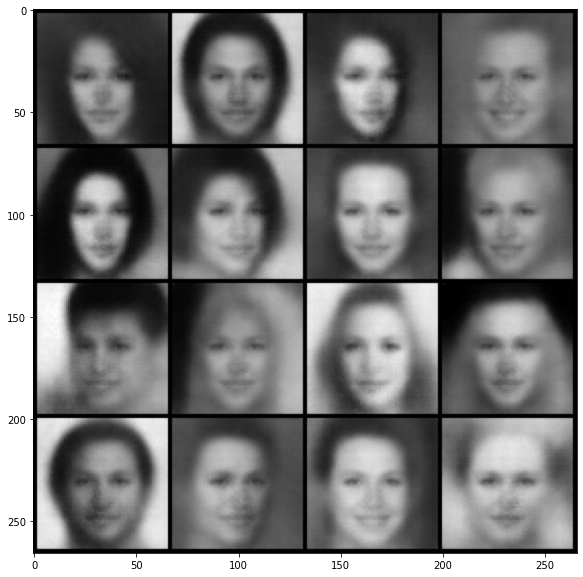

In [449]:
#honest_latent = torch.randn(16, dimZ).to(device)
honest_latent = mu_latent
rec_mu, rec_logvar = vae.decode(honest_latent)

reconstruction = rec_mu[:16].cpu().detach()

f, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

ax1.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

Even if in practice you do norandomsee the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [516]:
smilings_idxs = torch.nonzero(validation_dataset.attr[:, 31] == 1)
sad_idxs = torch.nonzero(validation_dataset.attr[:, 31] == 0)

In [517]:
some_smilings_idxs = np.random.choice(smilings_idxs[:, 0].numpy(), size=10 * BATCH_SIZE + 1, replace=False)
some_sad_idxs = np.random.choice(sad_idxs[:, 0].numpy(), size=10 * BATCH_SIZE, replace=False)

chosen_idx = some_smilings_idxs[0]
some_smilings_idxs = some_smilings_idxs[1:]

In [518]:
sad_batch = torch.cat(
    [validation_dataset[i][0].unsqueeze(0) for i in some_sad_idxs]
).to(device)
sad_codes = vae.encoder_mu(vae.encoder(sad_batch))

In [519]:
smilings_batch = torch.cat([validation_dataset[i][0].unsqueeze(0) for i in some_smilings_idxs]).to(device)
smilings_codes = vae.encoder_mu(vae.encoder(smilings_batch))

In [520]:
sad2happy = sad_codes.mean(dim=0) - smilings_codes.mean(dim=0)

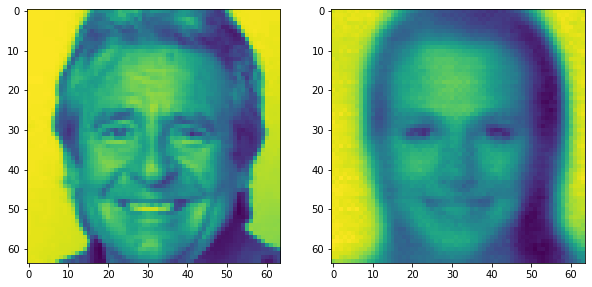

In [527]:
image = validation_dataset[chosen_idx][0].unsqueeze(0)
f, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

mu_gen, _, mu_latent, _ = vae(image.to(device), to_sample=False)

mu_sad2happy = [mu_latent + sad2happy * share for share in np.linspace(0., 2., num=25)]
mu_sad2happy = torch.cat(mu_sad2happy)

mu_gen_interpolation, d_var = vae.decode(mu_sad2happy.to(device))

ax1.imshow(image[0].permute(1, 2, 0).cpu().detach().numpy())
ax2.imshow(mu_gen_interpolation[0].cpu().detach().permute(1, 2, 0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


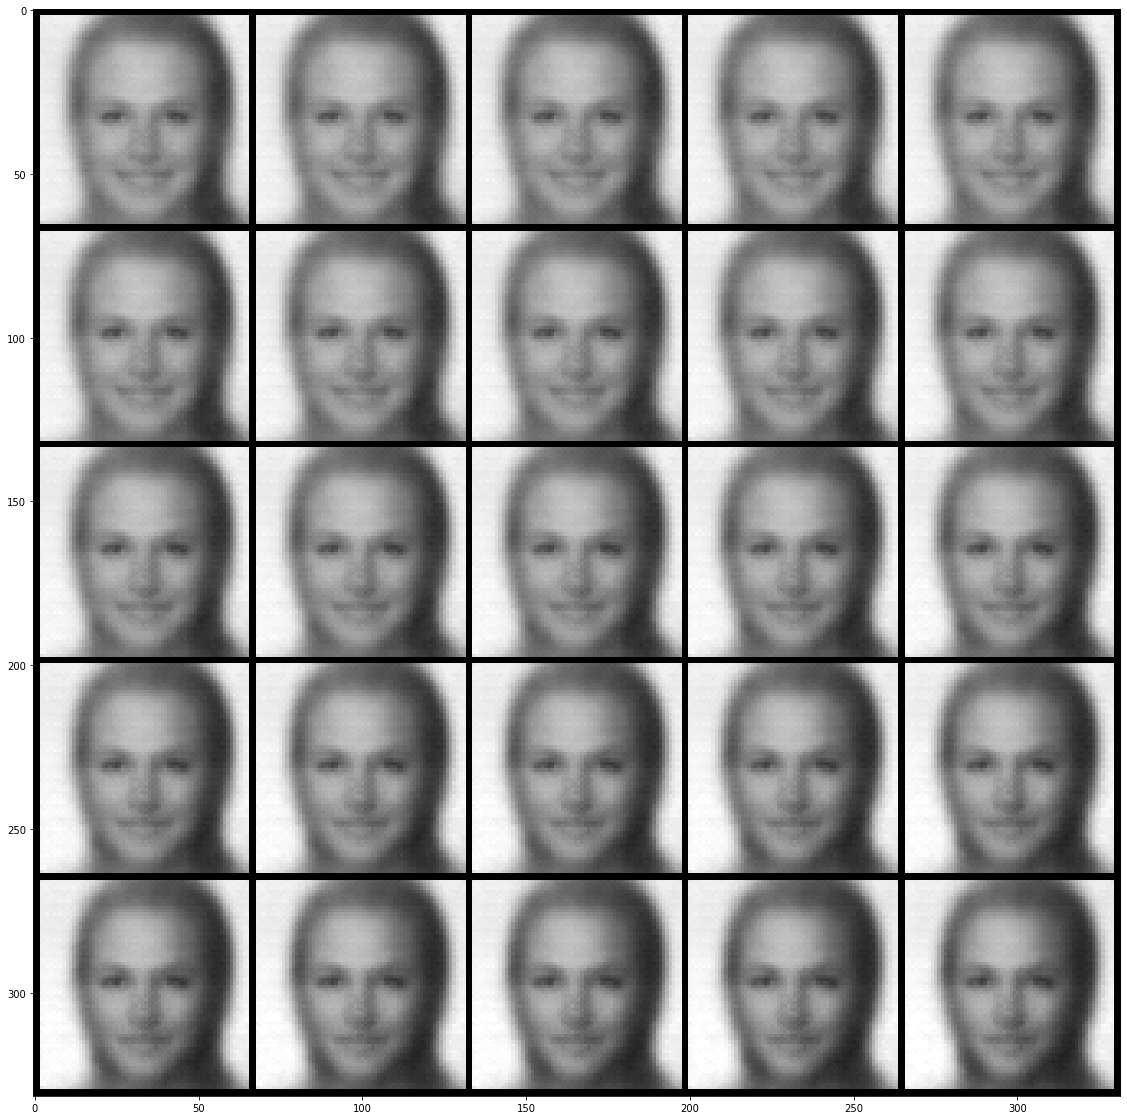

In [528]:
f, ax = plt.subplots(figsize=(20, 20))
plt.imshow(make_grid(mu_gen_interpolation, nrow=5).cpu().detach().permute(1, 2, 0))